# Graph connectivity and separation encoding

In [1]:
%matplotlib agg

import numpy as np
import scipy.spatial.distance
import matplotlib.pyplot as plt
from IPython.display import display

## Base graph

In [2]:
coords = np.array([
   [0.94532343, 2.01776379],
   [1.11885937, 3.66443598],
   [1.14899968, 5.06977875],
   [1.36761377, 6.2910276 ],
   [2.04615785, 7.60991947],
   [2.80677853, 6.24057681],
   [2.53300667, 4.80064445],
   [2.83406114, 3.23212271],
   [3.05026226, 1.53660729],
   [3.93193354, 1.35809879],
   [4.91434806, 1.72849903],
   [5.17482539, 2.58444179],
   [5.31857533, 4.25594418],
   [5.96061836, 5.48802393],
   [5.91422373, 7.00384843],
   [6.12377455, 8.03335182],
   [7.42662545, 8.88469539],
   [7.95408374, 8.40880505],
   [8.46730032, 7.44057995],
   [8.64579219, 6.44372214],
   [9.19389633, 4.97096978],
   [8.39282552, 4.05689322],
   [6.9636042 , 4.26153747],
   [6.70273117, 5.03772653]
])

def plot_sequence(coords, ax):
    ax.plot(*coords.T)
    ax.scatter(*coords.T)
    ax.set_xticks([])
    ax.set_yticks([])

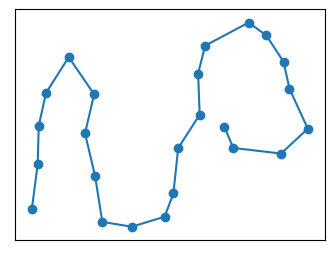

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
plot_sequence(coords, ax)
display(fig)
plt.close(fig)

## K-nearest
Connect every node with its k nearest neighbors

In [4]:
# The distances are returned in a condensed upper triangular form without the diagonal
distances = scipy.spatial.distance.pdist(coords)
senders, receivers = np.triu_indices(len(coords), k=1)
separation = receivers - senders - 1

df = pd.DataFrame({
    'sender': np.concatenate((senders, receivers)), 
    'receiver': np.concatenate((receivers, senders)), 
    'separation': np.concatenate((separation, separation)), 
    'distance': np.concatenate((distances, distances))
})
with pd.option_context('display.max_rows', 10):
    display(df.sort_values(by=['sender', 'receiver']))

,sender,receiver,separation,distance
0,0,1,0,1.655791
1,0,2,1,3.058804
2,0,3,2,4.294079
3,0,4,3,5.699477
4,0,5,4,4.614885
...,...,...,...,...
541,23,18,4,2.981176
545,23,19,3,2.398397
548,23,20,2,2.492059
550,23,21,1,1.954086


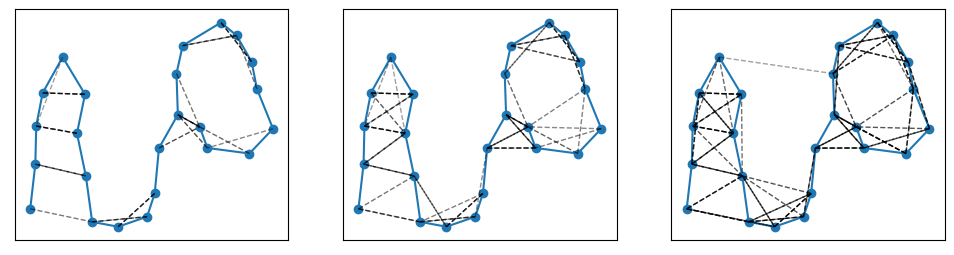

In [5]:
def plot_knearest(coords, dist_df, ax, k):
    knearest_df = dist_df.query('separation > 0').groupby('sender').apply(lambda g: g.nsmallest(k, 'distance'))
    knearest_df['alpha'] = np.exp(- (knearest_df.distance / knearest_df.distance.max()) ** 2)
    for s, r, _, dist, alpha in knearest_df.itertuples(index=False):
        xs = [coords[s][0], coords[r][0]]
        ys = [coords[s][1], coords[r][1]]
        ax.plot(xs, ys, alpha=alpha, color='k', linestyle='--', linewidth=1)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for k, ax in zip([1,2,3], axes.flat):
    plot_sequence(coords, ax)
    plot_knearest(coords, df, ax, k=k)
display(fig)
plt.close(fig)

## K-hop
Connect nodes within k-hops

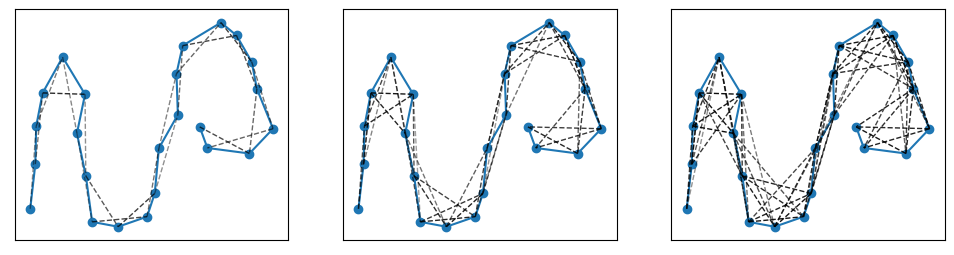

In [6]:
def plot_khops(coords, dist_df, ax, k):
    khops_df = dist_df.query(f'0 < separation <= {k} and sender < receiver').copy()
    khops_df['alpha'] = np.exp(- (khops_df.distance / khops_df.distance.max()) ** 2)
    for s, r, _, dist, alpha in khops_df.itertuples(index=False):
        xs = [coords[s][0], coords[r][0]]
        ys = [coords[s][1], coords[r][1]]
        ax.plot(xs, ys, alpha=alpha, color='k', linestyle='--', linewidth=1)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for k, ax in zip([1,2,3], axes.flat):
    plot_sequence(coords, ax)
    plot_khops(coords, df, ax, k=k)
display(fig)
plt.close(fig)

## Distance threshold
Connect nodes within a certain distance

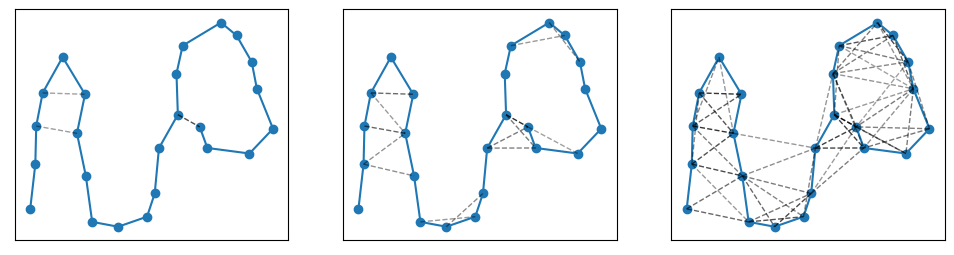

In [7]:
def plot_dist_cutoff(coords, dist_df, ax, cutoff):
    cutoff_df = dist_df.query(f'separation > 0  and distance <= {cutoff} and sender < receiver').copy()
    cutoff_df['alpha'] = np.exp(- (cutoff_df.distance / cutoff_df.distance.max()) ** 2)
    for s, r, _, dist, alpha in cutoff_df.itertuples(index=False):
        xs = [coords[s][0], coords[r][0]]
        ys = [coords[s][1], coords[r][1]]
        ax.plot(xs, ys, alpha=alpha, color='k', linestyle='--', linewidth=1)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for cutoff, ax in zip([1.5, 2, 3], axes.flat):
    plot_sequence(coords, ax)
    plot_dist_cutoff(coords, df, ax, cutoff=cutoff)
display(fig)
plt.close(fig)

## Separation encoding
One-hot encoding of separation according to range-based categories.

In [8]:
bins = [0, 1, 2, 3, 4, 5, 10]
labels = pd.Series(['0', '1', '2', '3', '4', '5:10', '10:'])
separation_enc = np.digitize(df.separation, bins=bins, right=False) - 1

df_enc = pd.concat([
    df.drop(columns='distance'),
    pd.Series(separation_enc).map(labels).rename('label').astype(pd.CategoricalDtype(labels, ordered=True)),
    pd.get_dummies(separation_enc)
], axis='columns')
with pd.option_context('display.max_rows', 25):
    display(df_enc.sort_values(by=['sender', 'receiver']))

,sender,receiver,separation,label,0,1,2,3,4,5,6
0,0,1,0,0,1,0,0,0,0,0,0
1,0,2,1,1,0,1,0,0,0,0,0
2,0,3,2,2,0,0,1,0,0,0,0
3,0,4,3,3,0,0,0,1,0,0,0
4,0,5,4,4,0,0,0,0,1,0,0
5,0,6,5,5:10,0,0,0,0,0,1,0
6,0,7,6,5:10,0,0,0,0,0,1,0
7,0,8,7,5:10,0,0,0,0,0,1,0
8,0,9,8,5:10,0,0,0,0,0,1,0
9,0,10,9,5:10,0,0,0,0,0,1,0
